In [ ]:
%pip install segmentation-models-pytorch
%pip install -U git+https://github.com/albumentations-team/albumentations
%pip install --upgrade opencv-contrib-python

# Dataset

Full dataset can be downloaded from:
Market-1501 dataset: https://www.kaggle.com/pengcw1/market-1501

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [3]:
DATA_DIR = 'dataset/train/'
CSV_FILE = 'dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'mps' # If running on M1 device
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # If running on Nvidia GPU

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [5]:
row = df.iloc[1]

a_img = io.imread(DATA_DIR + row.Anchor)
p_img = io.imread(DATA_DIR + row.Positive)
n_img = io.imread(DATA_DIR + row.Negative)

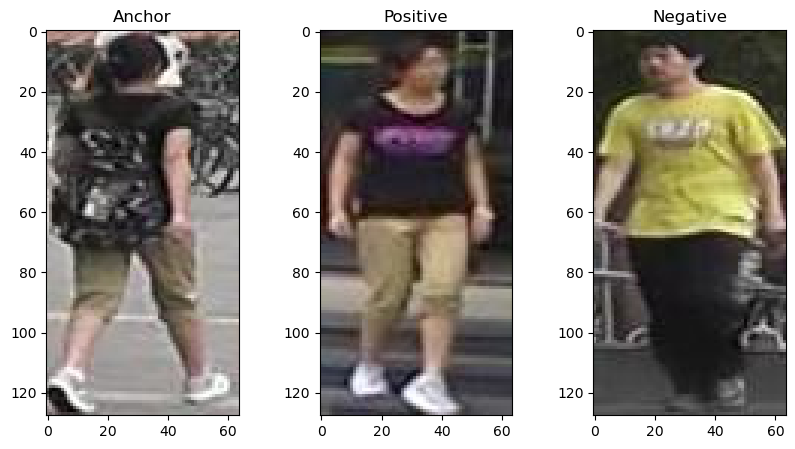

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(a_img)

ax2.set_title("Positive")
ax2.imshow(p_img)

ax3.set_title("Negative")
ax3.imshow(n_img)

In [7]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [8]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        a_img = io.imread(DATA_DIR + row.Anchor)
        p_img = io.imread(DATA_DIR + row.Positive)
        n_img = io.imread(DATA_DIR + row.Negative)

        a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
        p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
        n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

        return a_img, p_img, n_img

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

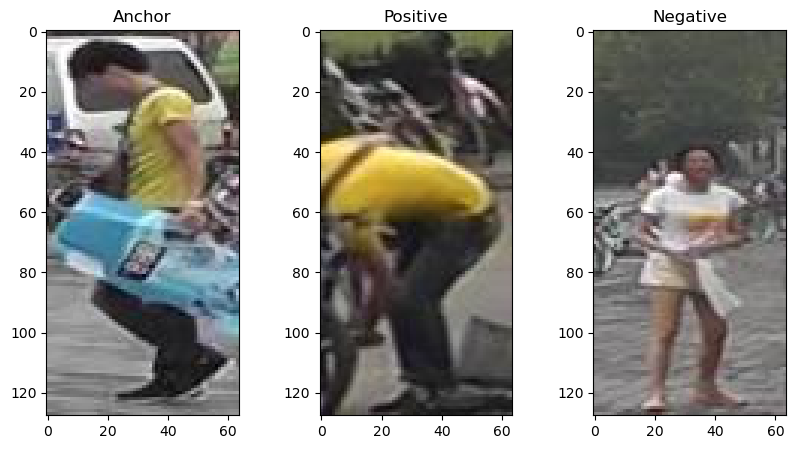

In [10]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [13]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [14]:
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)

        return embeddings

In [15]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [16]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train() # ON Dropout
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        a_embs = model(A)
        p_embs = model(P)
        n_embs = model(N)

        loss = criterion(a_embs, p_embs, n_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
def eval_fn(model, dataloader, criterion):

    model.eval() # OFF Dropout
    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            a_embs = model(A)
            p_embs = model(P)
            n_embs = model(N)

            loss = criterion(a_embs, p_embs, n_embs)

            total_loss += loss.item()

        return total_loss / len(dataloader)

In [18]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

# Get Anchor Embeddings

In [20]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc


In [21]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [01:05<00:00, 61.03it/s]


In [22]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.950370,-1.246682,0.264153,0.016563,0.161261,0.260944,-1.066897,-0.851131,-0.501846,...,0.396431,0.796691,0.370620,-0.305574,-0.802586,0.832391,-0.014612,-0.780868,0.033535,-0.147007
1,1420_c3s3_061978_03.jpg,-0.874382,-1.027276,0.114031,-0.025330,-0.146804,0.364442,-0.851687,-1.167470,-0.429265,...,0.297273,0.848780,0.015974,-0.269001,-0.729560,0.863343,0.417435,-0.458320,0.012786,-0.045416
2,1420_c5s3_062565_05.jpg,-0.792007,-0.739786,0.265643,0.158588,0.147455,0.315435,-1.193789,-0.961347,-0.484591,...,0.292309,0.415479,0.179154,-0.212643,-0.425254,0.698086,0.324745,-0.402244,0.290786,-0.232033
3,1420_c6s3_085592_04.jpg,-1.172355,-1.163967,0.230056,0.038692,0.209998,0.473312,-1.102231,-1.093161,-0.491990,...,0.448291,0.548428,0.141396,-0.224176,-0.459161,0.886780,0.317770,-0.386695,0.275751,-0.209607
4,0663_c5s3_085987_03.jpg,0.254456,0.760653,-0.321731,0.377706,0.164709,0.185855,0.210128,-0.181242,0.177117,...,0.392455,-0.354323,-0.051055,0.423935,0.157770,-0.146814,-0.303439,-0.190564,-0.383800,-0.002782


# Inference

In [23]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [24]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [25]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [26]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [27]:
closest_idx = np.argsort(distance)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


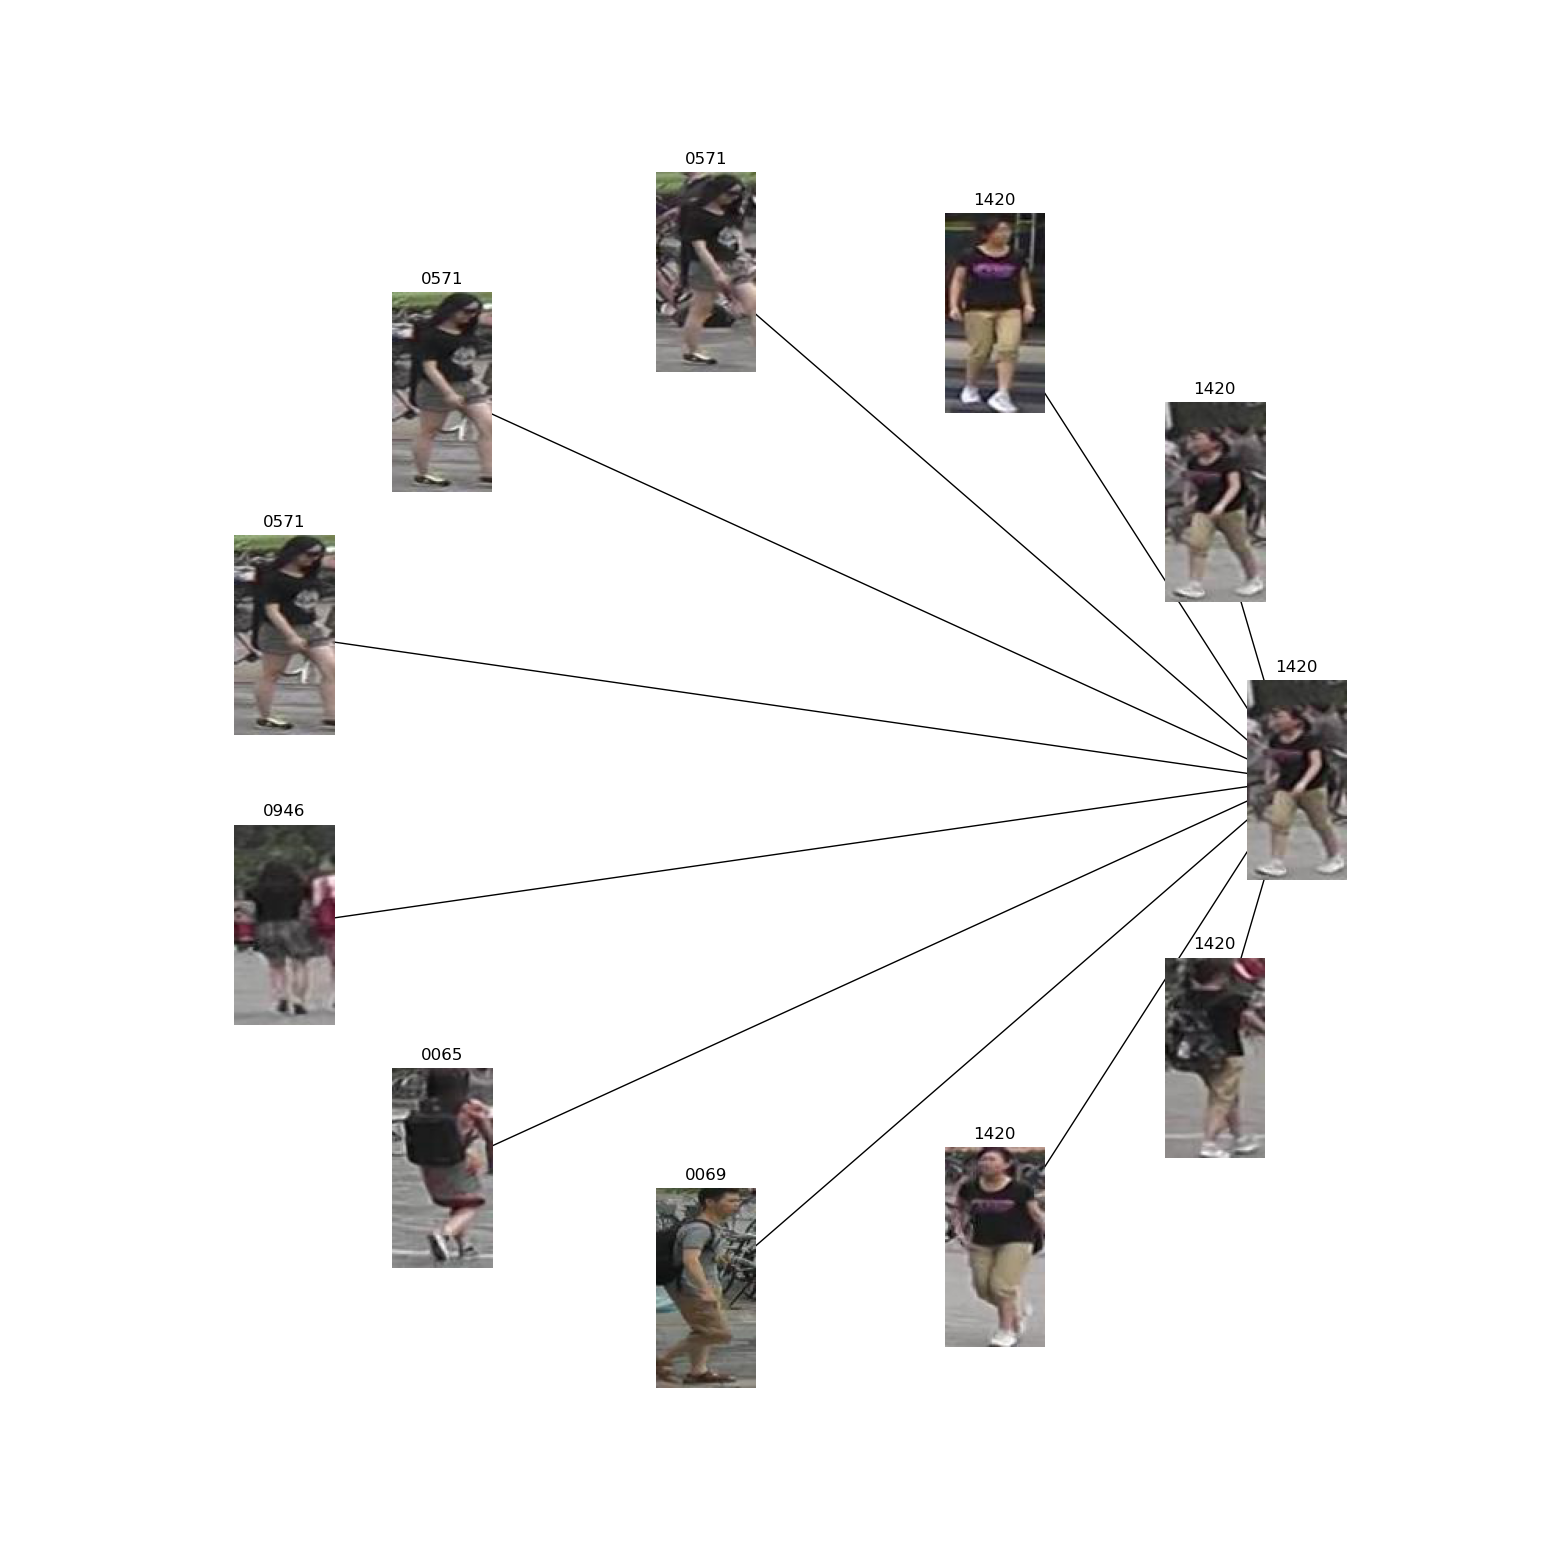

In [28]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);